<a href="https://colab.research.google.com/github/imsurgeon/dls-mipt/blob/master/GAN/HW_NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Апраксина Екатерина

Сделано на основе: https://nextjournal.com/gkoehler/pytorch-neural-style-transfer

In [1]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

from IPython.display import clear_output

In [2]:
torch.backends.cudnn.benchmark = True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda')

In [5]:
cnn = models.vgg19(pretrained=True).features.to(device).eval().requires_grad_(False)

In [6]:
# replace maxpools with avgpool

for (i, layer) in enumerate(cnn):
    if isinstance(layer, torch.nn.MaxPool2d):
        cnn[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

# Utility Functions

In [7]:
def im_convert(tensor):
    # convert tesnor to image, denormalize
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [8]:
def load_image(img_path, max_size=256, shape=None):
    
    image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [9]:
def get_features(image, model, layers=None):
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # content layer
                  '28': 'conv5_1'}
    
    features = {}
    x = image
    
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [10]:
def gram_matrix(tensor):

    batch_size, channels, height, width = tensor.size()
    tensor = tensor.view(batch_size * channels, height * width)
    gram = tensor @ tensor.t()
    
    return gram 

# Loading Images

In [11]:
content = load_image('content.jpg').to(device)

style_1 = load_image('style1.jpg', shape=content.shape[-2:]).to(device)
style_2 = load_image('style2.jpg', shape=content.shape[-2:]).to(device)

mask_img = Image.open('mask.jpg').convert('RGB')

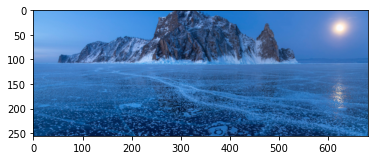

In [12]:
plt.imshow(im_convert(content))

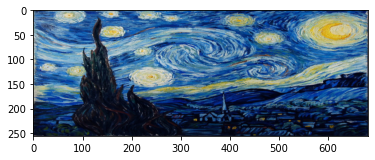

In [13]:
plt.imshow(im_convert(style_1))

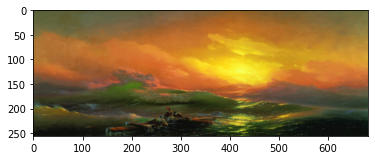

In [14]:
plt.imshow(im_convert(style_2))

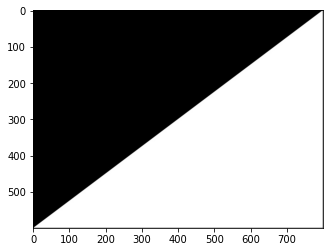

In [15]:
plt.imshow(np.asarray(mask_img))

In [16]:
content_features = get_features(content, cnn)
style_1_features = get_features(style_1, cnn)
style_2_features = get_features(style_2, cnn)

In [17]:
style_1_grams = {layer: gram_matrix(style_1_features[layer]) for layer in style_1_features}
style_2_grams = {layer: gram_matrix(style_2_features[layer]) for layer in style_2_features}

In [18]:
style_1_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

style_2_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1 
style_1_weight = 1e9
style_2_weight = 1e9

# The Style Transfer Loop (1)

In [23]:
target = content.clone().requires_grad_(True).to(device)

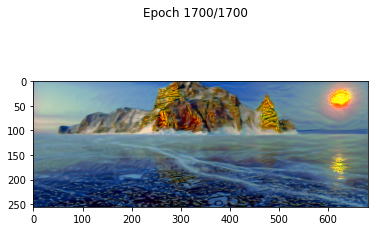

In [24]:
step = 100
optimizer = optim.Adam([target], lr=3e-3)
num_epochs = 1700 

for i in range(1, num_epochs+1):
    
    target_features = get_features(target, cnn)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_1_loss = 0
    style_2_loss = 0
        
    mask_transform = lambda size: transforms.Compose([transforms.Resize(size), transforms.ToTensor(),])
    resized_masks = {key:mask_transform(target_features[key].shape[2:4])(mask_img)[0].unsqueeze(0).unsqueeze(1).to(device)>0 for key in target_features}
    
    for layer in style_1_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        
        target_gram = gram_matrix(target_feature)
        
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_1_gram = style_1_grams[layer]
        style_2_gram = style_2_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_1_loss = style_1_weights[layer] * torch.mean((target_gram - style_1_gram)**2)
        layer_style_2_loss = style_2_weights[layer] * torch.mean((target_gram - style_2_gram)**2)
        # add to the style loss
        style_1_loss += layer_style_1_loss / (d * h * w)
        style_2_loss += layer_style_2_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_1_weight * style_1_loss + style_2_weight * style_2_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  i % step == 0:
        clear_output()
        plt.imshow(im_convert(target))
        plt.suptitle('Epoch %d/%d'%(i, num_epochs))
        plt.show()

# The Style Transfer Loop (2)

In [21]:
# Let's reinit target
target = content.clone().requires_grad_(True).to(device)

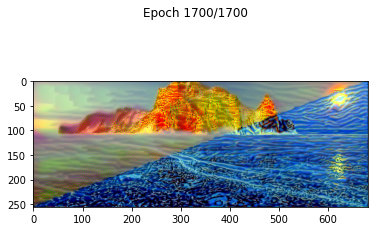

In [22]:
step = 100
optimizer = optim.Adam([target], lr=3e-3)
num_epochs = 1700
mask_transform = lambda size: transforms.Compose([transforms.Resize(size), transforms.ToTensor(),])
resized_masks = None

for i in range(1, num_epochs+1):
    
    target_features = get_features(target, cnn)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_1_loss = 0
    style_2_loss = 0
        
    
    if resized_masks is None:
        resized_masks = {key:mask_transform(target_features[key].shape[2:4])(mask_img)[0].unsqueeze(0).unsqueeze(1).to(device)>0 for key in target_features}
    
    for layer in style_1_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        mask = resized_masks[layer]
        
        target_1_gram = gram_matrix(target_feature*mask)
        target_2_gram = gram_matrix(target_feature*(~mask))
        
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_1_gram = style_1_grams[layer]
        style_2_gram = style_2_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_1_loss = style_1_weights[layer] * torch.mean((target_1_gram - style_1_gram)**2)
        layer_style_2_loss = style_2_weights[layer] * torch.mean((target_2_gram - style_2_gram)**2)
        # add to the style loss
        style_1_loss += layer_style_1_loss / (d * h * w)
        style_2_loss += layer_style_2_loss / (d * h * w)

    total_loss = content_weight * content_loss + style_1_weight * style_1_loss + style_2_weight * style_2_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  i % step == 0:
        clear_output()
        plt.imshow(im_convert(target))
        plt.suptitle('Epoch %d/%d'%(i, num_epochs))
        plt.show()